In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np
import xarray
from abtem.bloch import StructureFactor
from tqdm.auto import tqdm

import abtem

xarray.set_options(display_expand_data=False);

(appendix:convergence)=
# Convergence

In this tutorial, we go through how to ensure a multislice simulation with respect to the two major convergence parameters: slice thickness and real space sampling.

Note that what level of convergence is sufficient will depend on your specific calculation, and how fine sampling is required to reach the same level of convergence will depend not only on the calculation but also your specimen. The size of the ensemble when calculating ensemble means is another consideration, which will also be highly dependent on the system and measurement you are modeling.

We start by setting the precission to 64-bit floating point, the default is 32-bit, as calculations with extremely small samplings and slice thicknesses can lead to overflow. (Note: this tutorial requires `xarray` and `tqdm` to be installed.)

In [4]:
abtem.config.set({"precision": "float64"});

## Slice thickness

We now turn convergence with respect to slice thickness, our test system is a simulation diffraction patterns with an acceleration voltage of $200 \ \mathrm{keV}$ and a very fine real-space sampling of $0.02 \ \mathrm{Å}$.

Note that the faster the electron beam (higher the acceleration voltage), the larger is the slice thickness that can be used for converged results.

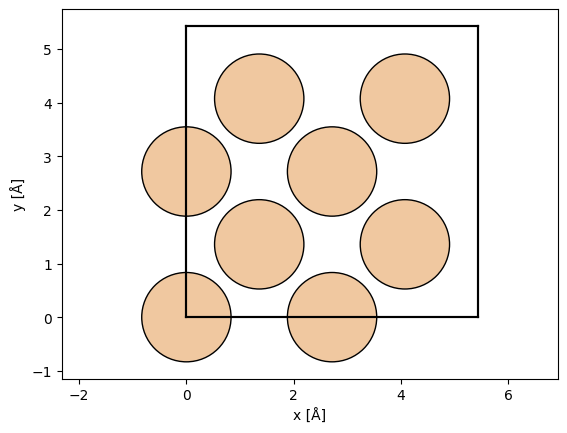

In [5]:
atoms = ase.build.bulk("Si", cubic=True)
abtem.show_atoms(atoms)

wave = abtem.PlaneWave(energy=200e3, sampling=0.02)

We use a geometric sequence halving the slice thickness at each step, starting from the thickness of the entire unit cell, $a/1, a/2, a/4, ..., a/256$.

In [6]:
a = atoms.cell[2, 2]

thickness_fractions = np.array([2**n for n in np.arange(0, 9)])

thicknesses = a / thickness_fractions

thicknesses

array([5.43      , 2.715     , 1.3575    , 0.67875   , 0.339375  ,
       0.1696875 , 0.08484375, 0.04242187, 0.02121094])

We test both finite and infinite potential integrals, below the calculations are set up.

In [7]:
# Initialize a dictionary to store exit wave data for different projections.
exit_waves_lists = {"finite": [], "infinite": []}

# Loop through specified slice thicknesses and projections.
for thickness in thicknesses:
    for projection in exit_waves_lists:

        # Create a potential for the given projection and thickness.
        potential_unit = abtem.Potential(
            atoms,
            projection=projection,
            slice_thickness=thickness,
            sampling=wave.sampling,
        )

        # Define a crystal potential with the potential unit repeated in the z-direction.
        potential = abtem.CrystalPotential(potential_unit, repetitions=(1, 1, 6))

        # Calculate the exit wave using the multislice method.
        exit_wave = wave.multislice(potential)

        # Append the exit wave to the corresponding list in the dictionary.
        exit_waves_lists[projection].append(exit_wave)

We stack all the results to allow for parallelization and to make further analysis easier.

In [8]:
# Define an OrdinalAxis object to represent metadata for the axis.
axes_metadata = abtem.core.axes.OrdinalAxis(
    label="slice thickness", values=[f"a/{f}" for f in thickness_fractions]
)

# Stack the finite exit waves along a new axis using the defined axes metadata.
stacks = [
    abtem.stack(value, axis_metadata=axes_metadata)
    for value in exit_waves_lists.values()
]

# Define new axes metadata, now labeling the axis as "projection"
axes_metadata = abtem.core.axes.OrdinalAxis(
    label="projection", values=list(exit_waves_lists.keys())
)

# Stack the finite and infinite exit waves along a new 'projection' axis.
exit_waves = abtem.stack(
    stacks,  # List of the two exit wave stacks to combine
    axis_metadata=axes_metadata,  # The new axis metadata
)

# Swap the first and second axes of the exit_waves array for plotting
exit_waves = abtem.array.swapaxes(exit_waves, 0, 1)

exit_waves.axes_metadata

type           label            coordinates
-------------  ---------------  ------------------
OrdinalAxis    slice thickness  -
OrdinalAxis    projection       -
RealSpaceAxis  x [Å]            0.00 0.02 ... 5.41
RealSpaceAxis  y [Å]            0.00 0.02 ... 5.41

Compute all the calculations.

In [10]:
exit_waves.compute();

We show the exit waves up to a slice thickness of $a/16$, as it becomes increasingly difficult to tell differences by eye by this point.

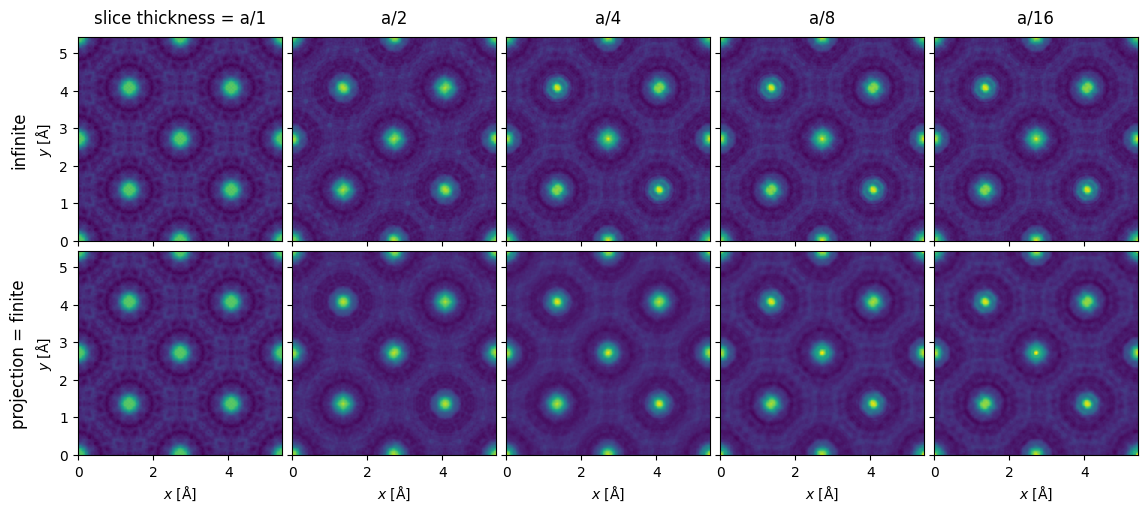

In [11]:
exit_waves[:5].show(explode=True, common_color_scale=True, figsize=(12, 6));

To make the comparison quantitative, we obtain the diffraction spots. We convert the *ab*TEM object to an Xarray `DataArray` to use its more powerful generic data manipulation tools, and the *ab*TEM `AxisMetadata` is converted to coordinates.

In [12]:
spots = (
    exit_waves.diffraction_patterns()
    .crop(140)
    .to_cpu()
    .index_diffraction_spots(atoms.cell, centering="F")
)

spots = spots**0.5

data = spots.to_data_array()

To calculate an error we need to choose a reference calculation; here we use the one with the finest finite projection integrals.

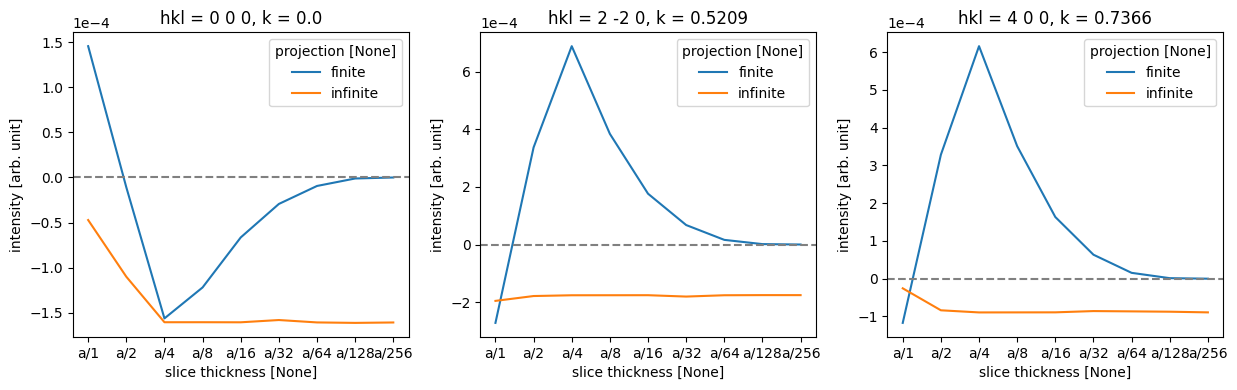

In [16]:
# Select the reference data point
reference = data.sel({"projection": "finite", "slice thickness": "a/256"})

# Calculate the difference between each data point in 'data' and the selected reference.
difference = data - reference

# Define a list of Miller indices to plot
miller_indices = [
    "0 0 0",
    "2 -2 0",
    "4 0 0",
]

# Create a 1-row, 3-column subplot structure and set the figure size.
fig, axes = plt.subplots(1, 3, figsize=(12.5, 4))

# Loop through each subplot axis and corresponding Miller index.
for ax, miller_index in zip(axes, miller_indices):
    # Plot the line graph of the difference data selected by Miller index,
    # with different lines for each projection.
    difference.sel(hkl=miller_index).plot.line(hue="projection", ax=ax)

    # Add a horizontal line at y=0 for reference
    ax.axhline(0, color="gray", linestyle="--")
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])

plt.tight_layout()

As there are four atomic planes in the unit cell, any slice thickness smaller than $a/4$ does not consistently improve the accuracy when using the infinite projection. Actually, any thickness that does not have $4$ as a factor may be slightly worse, since such a value requires shifting the atoms along $z$.

To quantify this further, we can use the R-factor, which in crystallography is used to assess the quality of a crystal structure model. The R-factor is a measure of the difference between the observed ($F_{obs}$) and calculated ($F_{calc}$) structure factor amplitudes:
$$
R = \frac{\sum |F_{\text{obs}} - F_{\text{calc}}|}{\sum |F_{\text{obs}}|}.
$$

We find that the R-factor is converged to within $1 \%$ for a slice thickness of $a/16$.

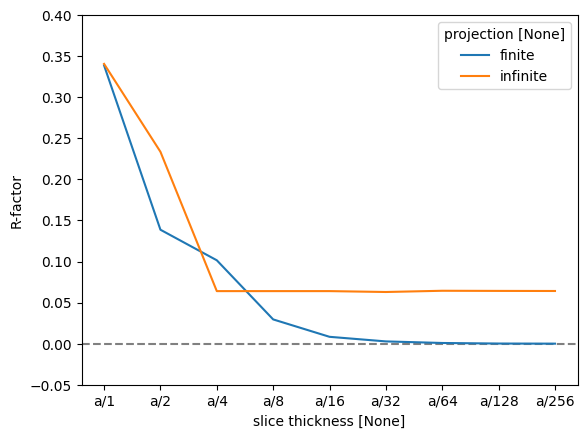

In [17]:
r_factor = np.abs(data - reference).sum("hkl") / np.abs(data).sum("hkl")

fig, ax = plt.subplots()
ax.axhline(0, color="gray", linestyle="--")
r_factor.plot.line(hue="projection", ax=ax)

ax.set_ylabel("R-factor")
ax.set_ylim([-0.05, 0.4]);

## Real-space sampling

Let us then use the slice thickness of $a/16$ with finite projection integrals to study the effect of real-space sampling (not to be confused with scan sampling for `GridScans`!)

Sufficiently dense sampling of the potential is vital for ensuring numerically converged calculations. Insufficient sampling may result in entirely unphysical results, or may manifest in atom-by-atom or column-by-column variability for identical sites due to small differences in how the potential grid samples the nuclear Couloumb potentials at different positions in the simulation cell. 

Our default value of $0.05\ \mathrm{Å}$ is a good compromise for speed and reliability for most systems. For specimen models containing only light elements (with relatively weak nuclear potentials), slightly larger values may produce acceptable results, whereas simulations of heavier elements as well as thicker specimens (where small numerical errors can accumulate), or when very high precision is required, may require smaller real-space sampling.

To ensure the best uniformity, it is also often beneficial to use sampling grids that are commensurate with the atomic positions, which in this case means also implies fractions of $a/4$. We use a geometric sequence halving the sampling at each step, but starting from the $1/16$ sampling of the entire unit cell, $a/16, ..., a/512$.

In [18]:
sampling_fractions = np.array([2**n for n in np.arange(4, 10)])
print(5.12 / sampling_fractions)

[0.32 0.16 0.08 0.04 0.02 0.01]


Since objects of different size cannot be stacked, we create supercells of the coarser samplings to retain the same size and make it easier to calculate and plot the results.

In [19]:
# Initialize a list to store exit wave data for different samplings.
exit_waves_list = []

sampling_fractions = np.array([2**n for n in np.arange(4, 10)])

# Loop through specified samplings.
for fraction in sampling_fractions:

        sampling = a / fraction

        # Create a potential for the given projection and thickness.
        potential_unit = abtem.Potential(
            atoms,
            projection='finite',
            slice_thickness=a/16,
            sampling=sampling,
        )

        # Define a crystal potential with the potential unit repeated.
        potential = abtem.CrystalPotential(potential_unit, repetitions=(sampling_fractions[-1]//fraction, sampling_fractions[-1]//fraction, 6))
    
        # Calculate the exit wave using the multislice method.
        exit_wave = wave.multislice(potential)

        # Append the exit wave to the corresponding list.
        exit_waves_list.append(exit_wave)

In [20]:
# Define an OrdinalAxis object to represent metadata for the axis.
axes_metadata = abtem.core.axes.OrdinalAxis(
    label="sampling", values=[f"a/{f}" for f in sampling_fractions]
)

# Stack the finite exit waves along a new axis using the defined axes metadata.
stack = abtem.stack(exit_waves_list, axis_metadata=axes_metadata)

tasks:   0%|          | 0/25 [00:00<?, ?it/s]

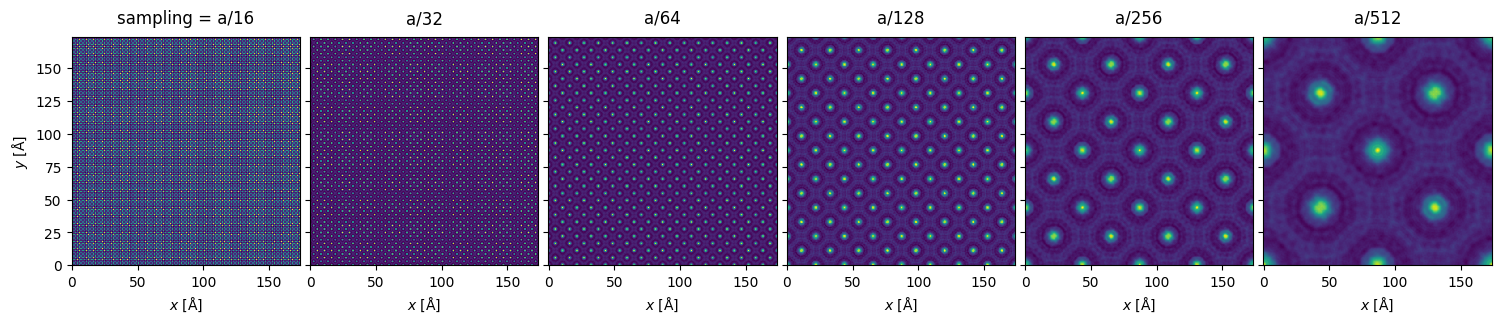

In [21]:
stack.show(explode=True, figsize=(16,6))

We can see visible aliasing artifacts appearing as vertical and horizontal lines of differing intensity. The maximum intensities also vary greatly due to differing sampling of the nuclear potentials (however, note that full convergence here is typically not necessary as we shall see below):

In [22]:
maxvals = stack.intensity().array.max(axis=(1,2))
print(maxvals)

dask.array<max-aggregate, shape=(6,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>


Especially in the $a / 64$ plot, we can also clearly see variation in the intensity of the atomic columns, which should not occur for our specimen.

Diffraction intensities are again a good way to quantify the effect of this; they have the further advantage, that they do not depend on the supercell size for periodic specimens.

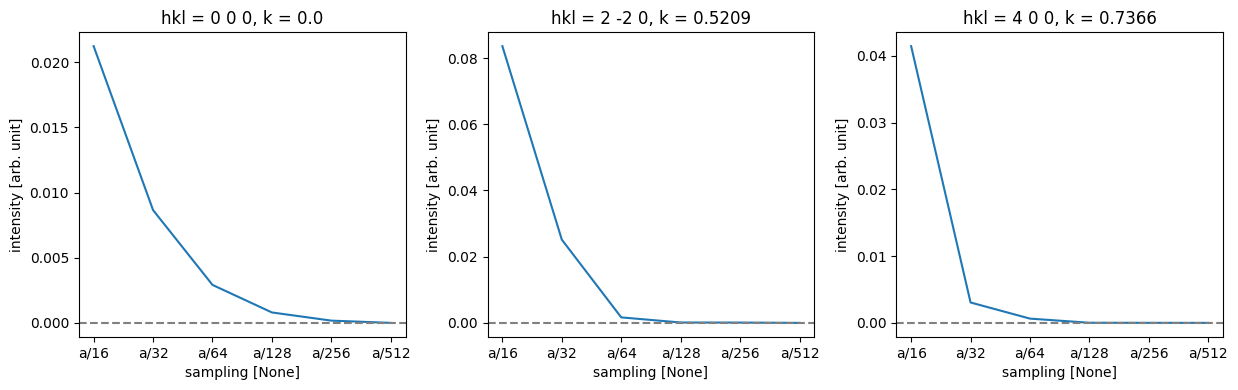

In [23]:
spots = (
    stack.diffraction_patterns()
    .crop(140)
    .to_cpu()
    .index_diffraction_spots(atoms.cell, centering="F")
)

spots = spots**0.5

data = spots.to_data_array()

# Select the reference data point
reference = data.sel({"sampling": "a/512"})

# Calculate the difference between each data point in 'data' and the selected reference.
difference = data - reference

# Define a list of Miller indices to plot
miller_indices = [
    "0 0 0",
    "2 -2 0",
    "4 0 0",
]

# Create a 1-row, 3-column subplot structure and set the figure size.
fig, axes = plt.subplots(1, 3, figsize=(12.5, 4))

# Loop through each subplot axis and corresponding Miller index.
for ax, miller_index in zip(axes, miller_indices):
    # Plot the line graph of the difference data selected by Miller index,
    # with different lines for each projection.
    difference.sel(hkl=miller_index).plot.line(ax=ax)

    # Add a horizontal line at y=0 for reference
    ax.axhline(0, color="gray", linestyle="--")
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])

plt.tight_layout()

Thus, we can see that while full convergence of the forward beam intensity requires extremely fine sampling, low-order diffraction spots are very well converged for a sampling of $a / 128 = 0.0424\ \mathrm{Å}$, but slightly coarser might be fine for this purpose.

Calculating the R-factor basically confirms this conclusion, though it is again more sensitive to small overall differences.

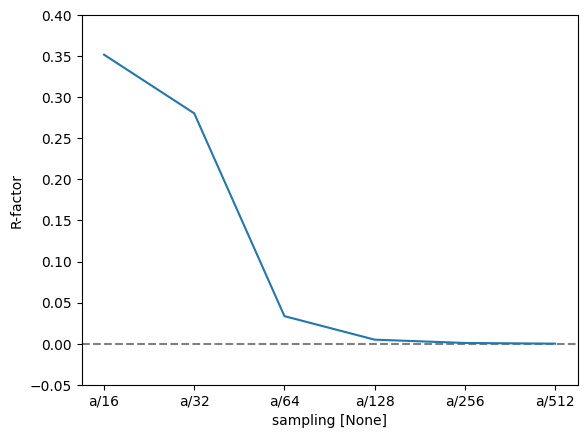

In [24]:
r_factor = np.abs(data - reference).sum("hkl") / np.abs(data).sum("hkl").data

fig, ax = plt.subplots()
ax.axhline(0, color="gray", linestyle="--")
r_factor.plot.line(hue="sampling", ax=ax)

ax.set_ylabel("R-factor")
ax.set_ylim([-0.05, 0.4]);